In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from tensorflow.python.keras.optimizer_v2.adam import Adam
import seaborn as sns

# READ DATASET

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
# Keeping only 2 classes which are AD and CTL
df = df[df.Class != 2]

In [3]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

In [4]:
labels = labels_df.iloc[:949,:2]

# PCA

In [5]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [6]:
x_train_225, x_test_225, y_train_225, y_test_225 = train_test_split(principalDf, labels, test_size= 0.2, random_state=42)

In [7]:
y_train_225 = y_train_225.astype(int)
y_test_225 = y_test_225.astype(int)

## MODEL

In [8]:
opt = tf.keras.optimizers.Adam(0.0001)

In [9]:
input_dim = principalDf.shape[1]

def build_model(optimizer=opt, init_mode='he_uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

In [10]:
ckpt = keras.callbacks.ModelCheckpoint(
        filepath='C:/Users/norma/Desktop/BITIRME/Models/MLP/best_model.{epoch:02d}-{val_accuracy:.4f}.h5',
        monitor='val_accuracy', save_best_only=True,verbose=1)

callbacks = [EarlyStopping(monitor='val_accuracy', patience=4, mode='auto', verbose=1, min_delta=0.0001),
         ckpt]

model = build_model(principalDf.shape[1])
history = model.fit(
          x = np.asarray(x_train_225).astype('float32'),
          y = y_train_225,
          steps_per_epoch=len(principalDf)//32,
          validation_data=(x_test_225, y_test_225),
          epochs=50,
          callbacks=[callbacks]
          )

Epoch 1/50
29/29 [==============================] - 2s 18ms/step - loss: 0.7341 - accuracy: 0.4664 - val_loss: 0.6935 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/norma/Desktop/BITIRME/Models/MLP\best_model.01-0.5000.h5
Epoch 2/50
29/29 [==============================] - 0s 10ms/step - loss: 0.7073 - accuracy: 0.5191 - val_loss: 0.6878 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/50
29/29 [==============================] - 0s 10ms/step - loss: 0.6965 - accuracy: 0.5007 - val_loss: 0.6817 - val_accuracy: 0.5842

Epoch 00003: val_accuracy improved from 0.50000 to 0.58421, saving model to C:/Users/norma/Desktop/BITIRME/Models/MLP\best_model.03-0.5842.h5
Epoch 4/50
29/29 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.5244 - val_loss: 0.6586 - val_accuracy: 0.6368

Epoch 00004: val_accuracy improved from 0.58421 to 0.63684, saving model to C:/Users/norma/Deskt

In [12]:
y_pred = model.predict(x_test_225)
y_pred_ = np.argmax(y_pred, axis=1)

class_d = 'C:/Users/norma/Desktop/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test = encoder.inverse_transform(y_test_225).ravel()

Classification report : 
               precision    recall  f1-score   support

           1       0.67      0.80      0.73        95
           0       0.75      0.61      0.67        95

    accuracy                           0.71       190
   macro avg       0.71      0.71      0.70       190
weighted avg       0.71      0.71      0.70       190



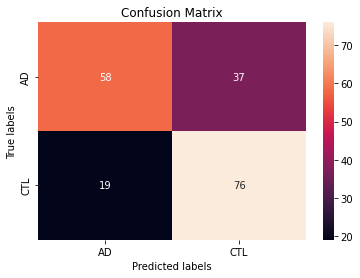

In [13]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred_,labels=[1,0])
print('Classification report : \n',matrix)

labels = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test, y_pred_)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


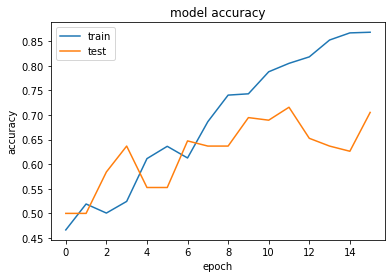

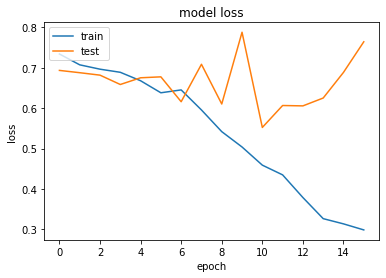

In [17]:
print("\n")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# AUC - ROC

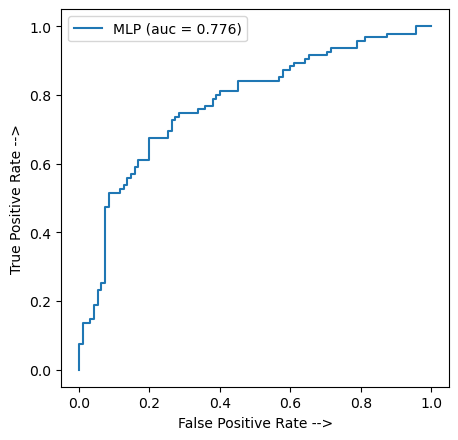

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
auc_mlp = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'MLP (auc = %0.3f)' % auc_mlp)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Model Save

In [18]:
model.save("C:/Users/norma/Desktop/src/MLP.h5")